# 图像增广
:label:`sec_image_augmentation`

 :numref:`sec_alexnet`提到过大型数据集是成功应用深度神经网络的先决条件。
图像增广在对训练图像进行一系列的随机变化之后，生成相似但不同的训练样本，从而扩大了训练集的规模。
此外，应用图像增广的原因是，随机改变训练样本可以减少模型对某些属性的依赖，从而提高模型的泛化能力。
例如，我们可以以不同的方式裁剪图像，使感兴趣的对象出现在不同的位置，减少模型对于对象出现位置的依赖。
我们还可以调整亮度、颜色等因素来降低模型对颜色的敏感度。
可以说，图像增广技术对于AlexNet的成功是必不可少的。本节将讨论这项广泛应用于计算机视觉的技术。


In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
# from d2l import torch as d2l

## 常用的图像增广方法

在对常用图像增广方法的探索时，我们将使用下面这个尺寸为$400\times 500$的图像作为示例。


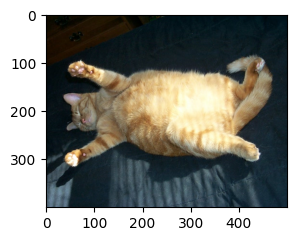

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

# 设置图像显示大小
plt.rcParams['figure.figsize'] = [3.5, 2.5]

# 打开并显示图像
img = Image.open('../img/cat1.jpg')
plt.imshow(img)
plt.show()

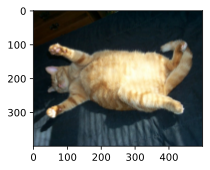

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img);

大多数图像增广方法都具有一定的随机性。为了便于观察图像增广的效果，我们下面定义辅助函数`apply`。
此函数在输入图像`img`上多次运行图像增广方法`aug`并显示所有结果。


In [4]:
import torch
import matplotlib.pyplot as plt

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # 当只有一张图片时，axes不是数组，需要转换
    if num_rows * num_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
        
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.show()  # 显示图像
    return axes

In [5]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale=scale)

### 翻转和裁剪

[**左右翻转图像**]通常不会改变对象的类别。这是最早且最广泛使用的图像增广方法之一。
接下来，我们使用`transforms`模块来创建`RandomFlipLeftRight`实例，这样就各有50%的几率使图像向左或向右翻转。


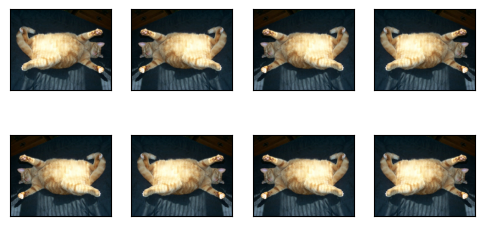

In [6]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

[**上下翻转图像**]不如左右图像翻转那样常用。但是，至少对于这个示例图像，上下翻转不会妨碍识别。接下来，我们创建一个`RandomFlipTopBottom`实例，使图像各有50%的几率向上或向下翻转。


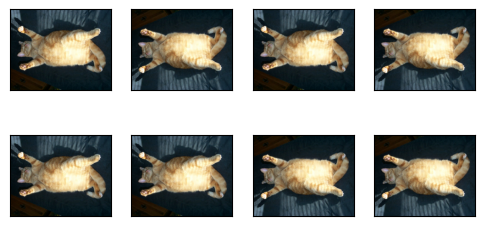

In [7]:
apply(img, torchvision.transforms.RandomVerticalFlip())

在我们使用的示例图像中，猫位于图像的中间，但并非所有图像都是这样。
在 :numref:`sec_pooling`中，我们解释了汇聚层可以降低卷积层对目标位置的敏感性。
另外，我们可以通过对图像进行随机裁剪，使物体以不同的比例出现在图像的不同位置。
这也可以降低模型对目标位置的敏感性。

下面的代码将[**随机裁剪**]一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5～2之间随机取值。
然后，区域的宽度和高度都被缩放到200像素。
在本节中（除非另有说明），$a$和$b$之间的随机数指的是在区间$[a, b]$中通过均匀采样获得的连续值。


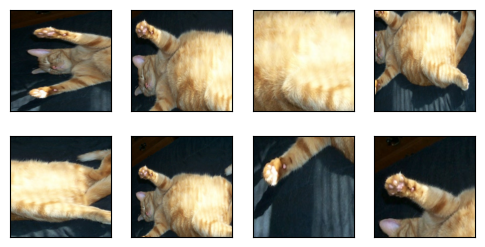

In [8]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### 改变颜色

另一种增广方法是改变颜色。
我们可以改变图像颜色的四个方面：亮度、对比度、饱和度和色调。
在下面的示例中，我们[**随机更改图像的亮度**]，随机值为原始图像的50%（$1-0.5$）到150%（$1+0.5$）之间。


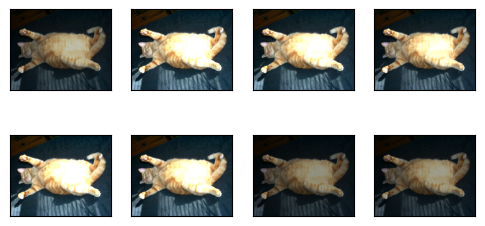

In [9]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

同样，我们可以[**随机更改图像的色调**]。


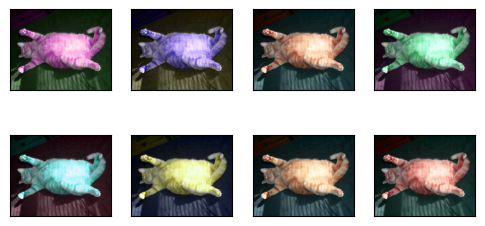

In [10]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

我们还可以创建一个`RandomColorJitter`实例，并设置如何同时[**随机更改图像的亮度（`brightness`）、对比度（`contrast`）、饱和度（`saturation`）和色调（`hue`）**]。


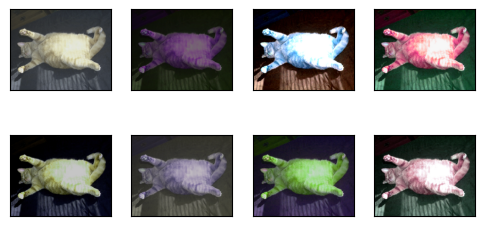

In [11]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### [**结合多种图像增广方法**]

在实践中，我们将结合多种图像增广方法。比如，我们可以通过使用一个`Compose`实例来综合上面定义的不同的图像增广方法，并将它们应用到每个图像。


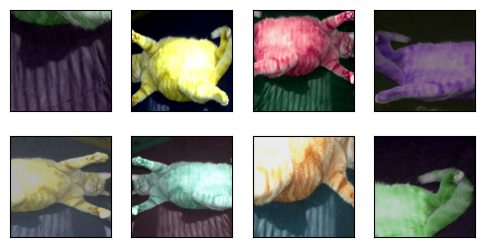

In [12]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

## [**使用图像增广进行训练**]

让我们使用图像增广来训练模型。
这里，我们使用CIFAR-10数据集，而不是我们之前使用的Fashion-MNIST数据集。
这是因为Fashion-MNIST数据集中对象的位置和大小已被规范化，而CIFAR-10数据集中对象的颜色和大小差异更明显。
CIFAR-10数据集中的前32个训练图像如下所示。


100.0%


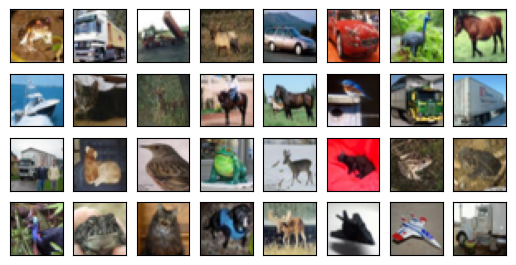

In [13]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，且在预测过程中不使用随机操作的图像增广。
在这里，我们[**只使用最简单的随机左右翻转**]。
此外，我们使用`ToTensor`实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数，取值范围为0～1。


In [14]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

接下来，我们[**定义一个辅助函数，以便于读取图像和应用图像增广**]。PyTorch数据集提供的`transform`参数应用图像增广来转化图像。有关`DataLoader`的详细介绍，请参阅 :numref:`sec_fashion_mnist`。


In [15]:
def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

In [16]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=get_dataloader_workers())
    return dataloader

### 多GPU训练

我们在CIFAR-10数据集上训练 :numref:`sec_resnet`中的ResNet-18模型。
回想一下 :numref:`sec_multi_gpu_concise`中对多GPU训练的介绍。
接下来，我们[**定义一个函数，使用多GPU对模型进行训练和评估**]。


In [17]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [18]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [19]:
def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [ ]:
import time
import numpy as np

class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()
    

In [24]:
from IPython import display

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        # 替换 d2l.use_svg_display()
        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = figsize
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 替换 d2l.set_axes，使用 lambda 函数直接配置参数
        self.config_axes = lambda: self._set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def _set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置坐标轴标签、范围和比例"""
        import matplotlib.pyplot as plt
        # 设置坐标轴标签
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        # 设置坐标轴范围
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        # 设置坐标轴比例
        if xscale:
            ax.set_xscale(xscale)
        if yscale:
            ax.set_yscale(yscale)
        # 设置图例
        if legend:
            ax.legend(legend)
        # 添加网格
        ax.grid(True)

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [25]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

现在，我们可以[**定义`train_with_data_aug`函数，使用图像增广来训练模型**]。该函数获取所有的GPU，并使用Adam作为训练的优化算法，将图像增广应用于训练集，最后调用刚刚定义的用于训练和评估模型的`train_ch13`函数。


In [27]:
import torch
from torch import nn
from torch.nn import functional as F
# from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

#@save
def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(
        64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

In [28]:
batch_size, devices, net = 256, try_all_gpus(), resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

让我们使用基于随机左右翻转的图像增广来[**训练模型**]。


KeyboardInterrupt: 

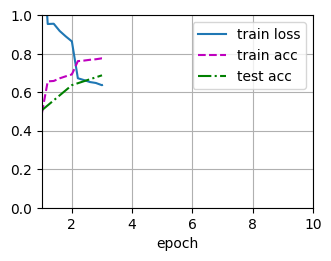

In [29]:
train_with_data_aug(train_augs, test_augs, net)

## 小结

* 图像增广基于现有的训练数据生成随机图像，来提高模型的泛化能力。
* 为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，而在预测过程中不使用带随机操作的图像增广。
* 深度学习框架提供了许多不同的图像增广方法，这些方法可以被同时应用。

## 练习

1. 在不使用图像增广的情况下训练模型：`train_with_data_aug(no_aug, no_aug)`。比较使用和不使用图像增广的训练结果和测试精度。这个对比实验能支持图像增广可以减轻过拟合的论点吗？为什么？
2. 在基于CIFAR-10数据集的模型训练中结合多种不同的图像增广方法。它能提高测试准确性吗？
3. 参阅深度学习框架的在线文档。它还提供了哪些其他的图像增广方法？


[Discussions](https://discuss.d2l.ai/t/2829)
